
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()

C:\Users\sugar\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [20 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [4]:
# your code here
scaler = MinMaxScaler()
X_train_scaled = X_train.copy()
X_train_scaled[X_train_scaled.columns] = scaler.fit_transform(X_train_scaled[X_train_scaled.columns])
X_train_scaled.describe()

X_test_scaled = X_test.copy()
X_test_scaled[X_test_scaled.columns] = scaler.transform(X_test_scaled[X_test_scaled.columns])

**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [5]:
# your code here
logit_allgenes=LogisticRegression(C=100000).fit(X_train_scaled.values, y_train)
y_train_pred_logit_allgenes=logit_allgenes.predict(X_train_scaled.values)
y_test_pred_logit_allgenes=logit_allgenes.predict(X_test_scaled.values)

print('The misclassification rate on the training set is {}%.'.format(100-accuracy_score(y_train,y_train_pred_logit_allgenes)*100))
print('The misclassification rate on the test set is {}%.'.format(100-accuracy_score(y_test,y_test_pred_logit_allgenes)*100))

The misclassification rate on the training set is 0.0%.
The misclassification rate on the test set is 22.516556291390728%.


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  eport the misclassification rate on both the train and test sets.**

In [6]:
# your code here
logistic_cv=LogisticRegressionCV(penalty='l1',solver='liblinear').fit(X_train_scaled.values, y_train)
y_train_pred_logit_cv=logistic_cv.predict(X_train_scaled.values)
y_test_pred_logit_cv=logistic_cv.predict(X_test_scaled.values)
print('The misclassification rate on the training set is {}%.'.format(100-accuracy_score(y_train,y_train_pred_logit_cv)*100))
print('The misclassification rate on the test set is {}%.'.format(100-accuracy_score(y_test,y_test_pred_logit_cv)*100))


The misclassification rate on the training set is 8.985024958402661%.
The misclassification rate on the test set is 13.907284768211923%.


**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [7]:
# your code here
ks = [1,2,3,4,5,7,9,10,15,25]
knnmodels = []
cv_scores = []
for k in ks:
    KNN = KNeighborsClassifier(n_neighbors = k)
    # train model with cv of 5
    cv_score = cross_val_score(KNN, X_train_scaled,y_train,cv=5)
    mean = np.mean(cv_score)
    cv_score = np.append(cv_score,mean)
    cv_scores.append(cv_score)
    knnmodels.append(KNN.fit(X_train_scaled,y_train))

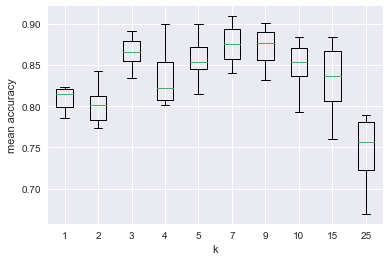

In [8]:
fig,ax=plt.subplots(1,1)
ax.boxplot(cv_scores)
ax.set_xticklabels(ks)
ax.set_ylabel('mean accuracy')
ax.set_xlabel('k')
plt.show()

When k=7 or 9, the the scores have high mean and relatively low variance. For pasymony, pick k=7.

In [9]:
KNN = KNeighborsClassifier(n_neighbors = 7)
KNN.fit(X_train_scaled,y_train)
knn_train_pred = KNN.predict(X_train_scaled)
knn_test_pred = KNN.predict(X_test_scaled)
accuracy_train = accuracy_score(y_train,knn_train_pred)
accuracy_test = accuracy_score(y_test,knn_test_pred)
mis_train = 1-accuracy_train
mis_test = 1-accuracy_test
print('The misclassification rate on train set of KNN model with k=7 is {}%'.format(100*mis_train))
print('The misclassification rate on test set of KNN model with k=7 is {}%'.format(100*mis_test))

The misclassification rate on train set of KNN model with k=7 is 9.816971713810318%
The misclassification rate on test set of KNN model with k=7 is 13.907284768211925%


**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

In [10]:
# your code here
from sklearn.metrics import confusion_matrix
#unregularized logistic  
cm1 = confusion_matrix(y_test, y_test_pred_logit_allgenes)
print('In unregularized model:')
print(cm1)
print('False positive rate: {}%'.format(100*cm1.ravel()[1]/(cm1.ravel()[1]+cm1.ravel()[0])))
print('False negative rate: {}%'.format(100*cm1.ravel()[2]/(cm1.ravel()[2]+cm1.ravel()[3])))
#lasso logistic 
cm2 = confusion_matrix(y_test, y_test_pred_logit_cv)
print('In LASSO logistic:')
print(cm2)
print('False positive rate: {}%'.format(100*cm2.ravel()[1]/(cm2.ravel()[1]+cm2.ravel()[0])))
print('False negative rate: {}%'.format(100*cm2.ravel()[2]/(cm2.ravel()[2]+cm2.ravel()[3])))
#knn
cm3 = confusion_matrix(y_test, knn_test_pred)
print('In KNN:')
print(cm3)
print('False positive rate: {}%'.format(100*cm3.ravel()[1]/(cm3.ravel()[1]+cm3.ravel()[0])))
print('False negative rate: {}%'.format(100*cm3.ravel()[2]/(cm3.ravel()[2]+cm3.ravel()[3])))

In unregularized model:
[[65 12]
 [22 52]]
False positive rate: 15.584415584415584%
False negative rate: 29.72972972972973%
In LASSO logistic:
[[67 10]
 [11 63]]
False positive rate: 12.987012987012987%
False negative rate: 14.864864864864865%
In KNN:
[[67 10]
 [11 63]]
False positive rate: 12.987012987012987%
False negative rate: 14.864864864864865%


*your answer here*  
With the default probability threshold (0.5), LASSO-logistic and KNN models gives better prediction than the unregularized model. One possible reason is that the unregularized model uses too many predictors, and may contain unnecessary information.

<div class='exercise'><b> Question 2 [20 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice with 1-3 sentences.

<hr>

### Solutions

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [11]:
# your code here
from sklearn.preprocessing import StandardScaler

scaler_pca = StandardScaler()
X_train_scaled_pca = X_train.copy()
X_train_scaled_pca[X_train_scaled_pca.columns] = scaler_pca.fit_transform(X_train_scaled_pca[X_train_scaled_pca.columns])

X_test_scaled_pca = X_test.copy()
X_test_scaled_pca[X_test_scaled_pca.columns] = scaler_pca.transform(X_test_scaled_pca[X_test_scaled_pca.columns])


In [12]:
pca = PCA()
pca_train = pca.fit(X_train_scaled_pca) 
pca_train_X = pca_train.transform(X_train_scaled_pca)
pca_test_X = pca_train.transform(X_test_scaled_pca)
print('The shape of PCA decomposition of X_train is {}'.format(pca_train_X.shape))
print('The shape of PCA decomposition of X_test is {}'.format(pca_test_X.shape))

The shape of PCA decomposition of X_train is (601, 601)
The shape of PCA decomposition of X_test is (151, 601)


*Your answer here*  
The maximum number of PCA components is bound by the smaller number of number of observations and number of columns. 

**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

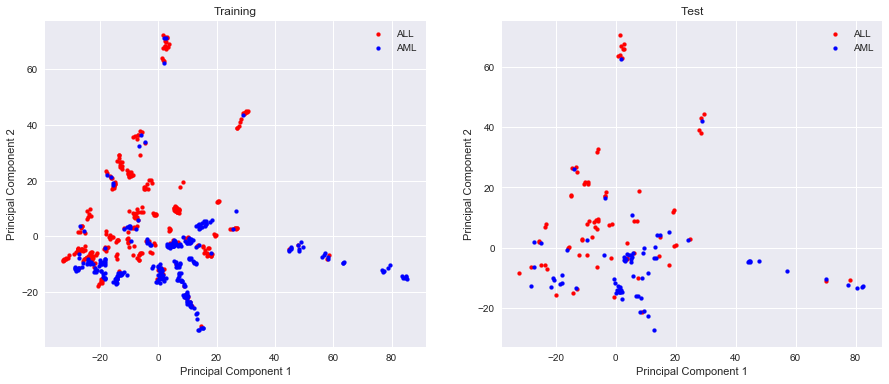

In [13]:
# your code here
colors = ['r','b']
label_text = ["ALL", "AML"]

fig, axes=plt.subplots(1,2,figsize=(15,6))
for outcome in [0,1]:
    outcome_df = pca_train_X[y_train==outcome]
    axes[0].scatter(outcome_df[:,0], outcome_df[:,1], c = colors[outcome], label=label_text[outcome],s=15)
    axes[0].legend()
    axes[0].set_title('Training')
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')
    
for outcome in [0,1]:
    outcome_df = pca_test_X[y_test==outcome]
    axes[1].scatter(outcome_df[:,0], outcome_df[:,1], c = colors[outcome], label=label_text[outcome],s=15)
    axes[1].legend()
    axes[1].set_title('Test')
    axes[1].set_xlabel('Principal Component 1')
    axes[1].set_ylabel('Principal Component 2')


*your answer here*  
In the list of p principle components Z1,..., Zp, the Zi 's are ordered in decreasing order in the amount of captured observed variance. Therefore the top 2 components can retain majority of information and best classify the outcome.


**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

The variance explained in X_train based on the principle component 1 is 6.28154588325458%.
The variance explained in X_train based on the principle component 2 is 4.938132889509878%.
The variance explained in X_train based on the top 2 PCA vectors is 11.219678772764457%.
232 PCA vectors are needed so that 90% of the variability is explained.


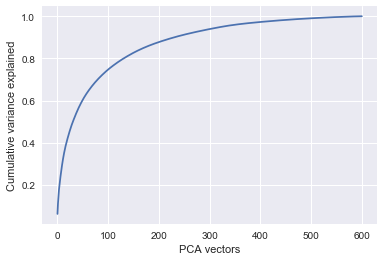

In [14]:
# your code here
print('The variance explained in X_train based on the principle component 1 is {}%.'.format(100*pca_train.explained_variance_ratio_[0]))
print('The variance explained in X_train based on the principle component 2 is {}%.'.format(100*pca_train.explained_variance_ratio_[1]))
var_2vec = np.sum(pca_train.explained_variance_ratio_[0:2])
print('The variance explained in X_train based on the top 2 PCA vectors is {}%.'.format(100*var_2vec))
cumsum = np.cumsum(pca_train.explained_variance_ratio_)
vec_needed=np.where(cumsum >= 0.9)
print('{} PCA vectors are needed so that 90% of the variability is explained.'.format(vec_needed[0][0]+1))

ind = [i for i in range(len(cumsum))]
plt.plot(ind, cumsum)
plt.xlabel('PCA vectors')
plt.ylabel('Cumulative variance explained')

**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and ustify your choice in 1-3 sentences.**

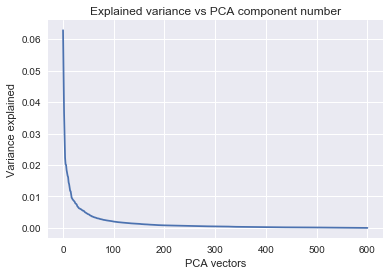

In [15]:
#your code here
plt.plot(ind, pca_train.explained_variance_ratio_)
plt.xlabel('PCA vectors')
plt.ylabel('Variance explained')
plt.title('Explained variance vs PCA component number')

The reasonable value for the number of components is 100 because starting from 100th PCA vector, the explained variance is very close to 0 and thus not very representative. Even though some components after the 100th also capture some variance, but to minimize overfitting, I decide to exclude these vectors from the model.

<div class='exercise'><b> Question 3 [30 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [16]:
# your code here
logreg=LogisticRegression(C=100000,fit_intercept=True, solver='liblinear')

# 1. with just the first 2 PCA vectors
logreg.fit(pca_train_X[:,0:2],y_train.values.ravel())

#model on test model
pred_test_1 = logreg.predict(pca_test_X[:,0:2])
pred_train_1 = logreg.predict(pca_train_X[:,0:2])
accuracy_test=accuracy_score(y_test,pred_test_1,normalize=True)
accuracy_train=accuracy_score(y_train,pred_train_1,normalize=True)

print('The misclassification rate of the first logreg model on training set is {}%'.format((1-accuracy_train)*100))
print('The misclassification rate of the first logreg model on test set is {}%'.format((1-accuracy_test)*100))

# 2. with the number of component vectors your chose from 2.4 above
n_components = 100
logreg.fit(pca_train_X[:,0:n_components],y_train.values.ravel())

pred_test_2 = logreg.predict(pca_test_X[:,0:n_components])
pred_train_2 = logreg.predict(pca_train_X[:,0:n_components])
accuracy_test=accuracy_score(y_test,pred_test_2,normalize=True)
accuracy_train=accuracy_score(y_train,pred_train_2,normalize=True)

print('The misclassification rate of the second model on training set is {}%'.format((1-accuracy_train)*100))
print('The misclassification rate of the second model on test set is {}%'.format((1-accuracy_test)*100))

# your code here 

# 3. with the number of components that explain at least 90% of the variability

logreg.fit(pca_train_X[:,0:232],y_train.values.ravel())

#model on test model
pred_test_3 = logreg.predict(pca_test_X[:,0:232])
pred_train_3 = logreg.predict(pca_train_X[:,0:232])

accuracy_test=accuracy_score(y_test,pred_test_3,normalize=True)
accuracy_train=accuracy_score(y_train,pred_train_3,normalize=True)
print('The misclassification rate of the third model on training set is {}%'.format((1-accuracy_train)*100))
print('The misclassification rate of the third model on test set is {}%'.format((1-accuracy_test)*100))

The misclassification rate of the first logreg model on training set is 24.126455906821963%
The misclassification rate of the first logreg model on test set is 23.178807947019862%
The misclassification rate of the second model on training set is 8.485856905158073%
The misclassification rate of the second model on test set is 16.55629139072847%
The misclassification rate of the third model on training set is 0.0%
The misclassification rate of the third model on test set is 25.82781456953642%


*your answer here*  
For test set, LASSO-logistic and KNN model have the best classification accuracy with lowest misclassication rate of 0.139. The PCA models have the misclassification on test set around 0.2. 

For train set, The misclassification rate for PCA models are very dependent on the number of components chosen. When we chose a large number of components, the accuracy rate is high but the test set accuracy is very low. When we chose components number to be 2, the train set variance is not well captured, and thus the accuracy rate for train set is also very low (missclassification = 0.24).

**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

In [17]:
components = [2,10,25,50,60,70,80,90,100,150,200,232,250,300,350,400,450,500,550,601]
pcamodels = []
cv_scores_pca = []
for k in components:
    logit_pca = LogisticRegression(C=100000,fit_intercept=True, solver='liblinear')
    # train model with cv of 5
    cv_score = cross_val_score(logit_pca, pca_train_X[:,0:k],y_train,cv=5)
    mean = np.mean(cv_score)
    cv_score = np.append(cv_score,mean)
    cv_scores_pca.append(cv_score)
    pcamodels.append(logit_pca.fit(pca_train_X[:,0:k],y_train))

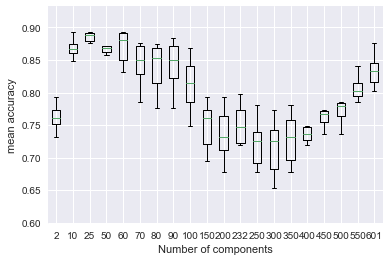

In [18]:
fig,ax=plt.subplots(1,1)
ax.boxplot(cv_scores_pca)
ax.set_xticklabels(components)
ax.set_ylabel('mean accuracy')
ax.set_xlabel('Number of components')
plt.show()

The model with 25 components seems good (high mean accuracy and low variance). 

In [19]:
X_train.columns.get_loc('M31523_at')

6854

In [20]:
pca_25=pcamodels[2]
sum_effect=0
for i in range(25):
    sum_effect+= pca.components_[0:25][i][6854]*pca_25.coef_[0][i]
sum_effect

-0.014916248704635411

In [21]:
np.exp(sum_effect)

0.98519444745910523

The slope (coefficient) of M31523_at in this model is -0.0149. Holding all other constant, the odds of having AML against ALL is 0.985 times of the odds of having AML against ALL among those with one unit less M31523_at expression.

**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

*your answer here*  
The ROC curve is a graph illustrating the disrimination capability of a binary classifer at all classification thresholds, created by plotting true positive rate against the false positive rate at different thresholds. AUC is the two-dimentional area under the roc curve, which represents the degree of separability or the capability of a binary classifier in discriminating two classes.

The misclassification rate measure of a model depends on the threshold chosen, whereas AUC gives an broader aggregate measure of performance across all possible discrimination thresholds. If we change our threshold in previous questions, our calculated misclassification rate will change accordingly. But AUC is not dependent on threshold so it is prefered for evaluating models.

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

In [22]:
# your code here
#colors=['r','b','g','c','m','y','k']
def plot_roc(model,x,y,i,color,name):
    preds=model.predict_proba(x)[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, color, label = str(name)+' AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right',fontsize=12)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

C:\Users\sugar\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


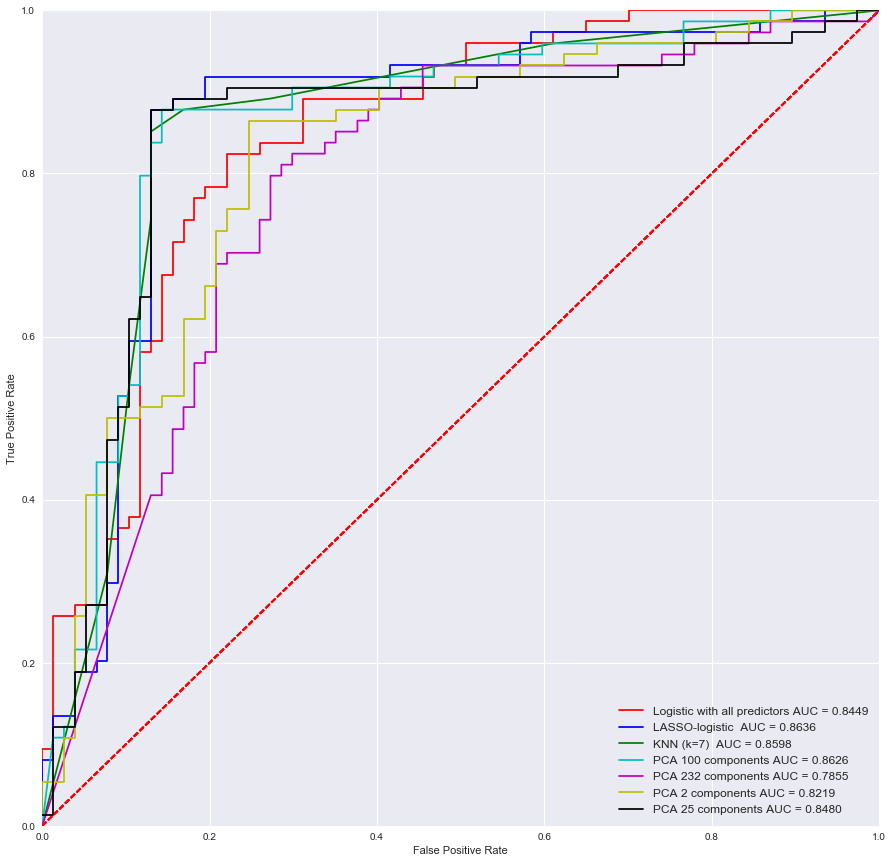

In [23]:
plt.figure(figsize=(15,15))
plot_roc(logit_allgenes,X_test_scaled,y_test,0,'r',name='Logistic with all predictors')
plot_roc(logistic_cv,X_test_scaled,y_test,1,'b',name='LASSO-logistic ')
plot_roc(KNN.fit(X_train_scaled,y_train),X_test_scaled,y_test,1,'g',name='KNN (k=7) ')
plot_roc(logreg.fit(pca_train_X[:,0:100],y_train.values.ravel()),pca_test_X[:,0:100],y_test,1,'c',name='PCA 100 components')
plot_roc(logreg.fit(pca_train_X[:,0:232],y_train.values.ravel()),pca_test_X[:,0:232],y_test,1,'m',name='PCA 232 components')
plot_roc(logreg.fit(pca_train_X[:,0:2],y_train.values.ravel()),pca_test_X[:,0:2],y_test,1,'y',name='PCA 2 components')
plot_roc(logreg.fit(pca_train_X[:,0:25],y_train.values.ravel()),pca_test_X[:,0:25],y_test,1,'k',name='PCA 25 components')

*your answer here*  
If there are models with close AUC, we can choose appropriate model based on other consideration, such as calculation efficiency, AIC (Akaike information criteria), interpretability. We tend to use model that takes shorter time to fit and calculate. We tend to use model with less AIC. We tend to use parametric model rather than non-parametric model since parametric model is more logical to explain and interpret. 

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

*your answer here*  
The models of LASSO logistic, KNN, normal logistic, PCA 100 components and PCA 25 components have similar AUC. In practice use, I prefer to use LASSO logistic first due to its interpretability and good AUC, and see if I can find supporting conclusions from KNN and PCA 100 models. 


<div class='exercise'><b> Question 4: COMPAS [30 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.**

In [24]:
compas_df = pd.read_csv('data/compas.csv')
# your code here

compas_df_new=compas_df.copy()
compas_df_new['c_charge_degree'] = (compas_df_new['c_charge_degree'] == 'F') * 1
compas_df_new.loc[compas_df_new['score_text'] == 'Low','score_text'] = 0
compas_df_new.loc[compas_df_new['score_text'] == 'Medium','score_text'] = 1
compas_df_new.loc[compas_df_new['score_text'] == 'High','score_text'] = 2
compas_df_new = pd.get_dummies(compas_df_new, columns=['race', 'sex'])#, drop_first=True)
compas_df_new=compas_df_new.drop(['c_charge_desc'],axis=1)
compas_df_new.head()

age  c_charge_degree  score_text  priors_count  juv_fel_count  \
0   69                1           0             0              0   
1   34                1           0             0              0   
2   24                1           0             4              0   
3   44                0           0             0              0   
4   41                1           1            14              0   

   juv_misd_count  juv_other_count  decile_score  two_year_recid  \
0               0                0             1               0   
1               0                0             3               1   
2               0                1             4               1   
3               0                0             1               0   
4               0                0             6               1   

   length_of_stay  priors_1  priors_234    ...     charge_any_drug  \
0               1         0           0    ...                   0   
1              10         0           0    ...                   0   
2               1         0           1    ...                   1   
3               1         0           0    ...                   0   
4               6         0           0    ...                   0   

   charge_any_violence_aggression  charge_any_theft  length_of_stay_thresh  \
0                               1                 0                      1   
1                               1                 0                     10   
2                               0                 0                      1   
3                               1                 0                      1   
4                               0                 1                      6   

   race_African-American  race_Asian  race_Caucasian  race_Hispanic  \
0                      0           0               0              0   
1                      1           0               0              0   
2                      1           0               0              0   
3                      0           0               0              0   
4                      0           0               1              0   

   race_Native American  race_Other  sex_Female  sex_Male  
0                     0           1           0         1  
1                     0           0           0         1  
2                     0           0           0         1  
3                     0           1           0         1  
4                     0           0           0         1  

[5 rows x 28 columns]

In [25]:
X_train_compas, X_test_compas, y_train_compas, y_test_compas =train_test_split(compas_df_new.loc[:, compas_df_new.columns != 'two_year_recid'], 
                                                         compas_df_new.two_year_recid, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = compas_df.race)

In [26]:
X_train_compas.shape

(4937, 27)

In [27]:
X_test_compas.shape

(1235, 27)

**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

In [28]:
from scipy.stats import ttest_ind
droplist=['race_African-American','race_Asian','race_Caucasian','race_Hispanic','race_Native American','race_Other','sex_Female']
compas_caucasians=compas_df_new[compas_df_new.race_Caucasian==1]
compas_african=compas_df_new[compas_df_new['race_African-American']==1]
compas_caucasians=compas_caucasians.drop(droplist,axis=1)
compas_african=compas_african.drop(droplist,axis=1)
significant_index=ttest_ind(compas_caucasians, compas_african,equal_var = False)[1].argsort()[:3]
significant_variables = compas_caucasians.columns[significant_index]
significant_variables

Index(['decile_score', 'score_text', 'priors_count'], dtype='object')

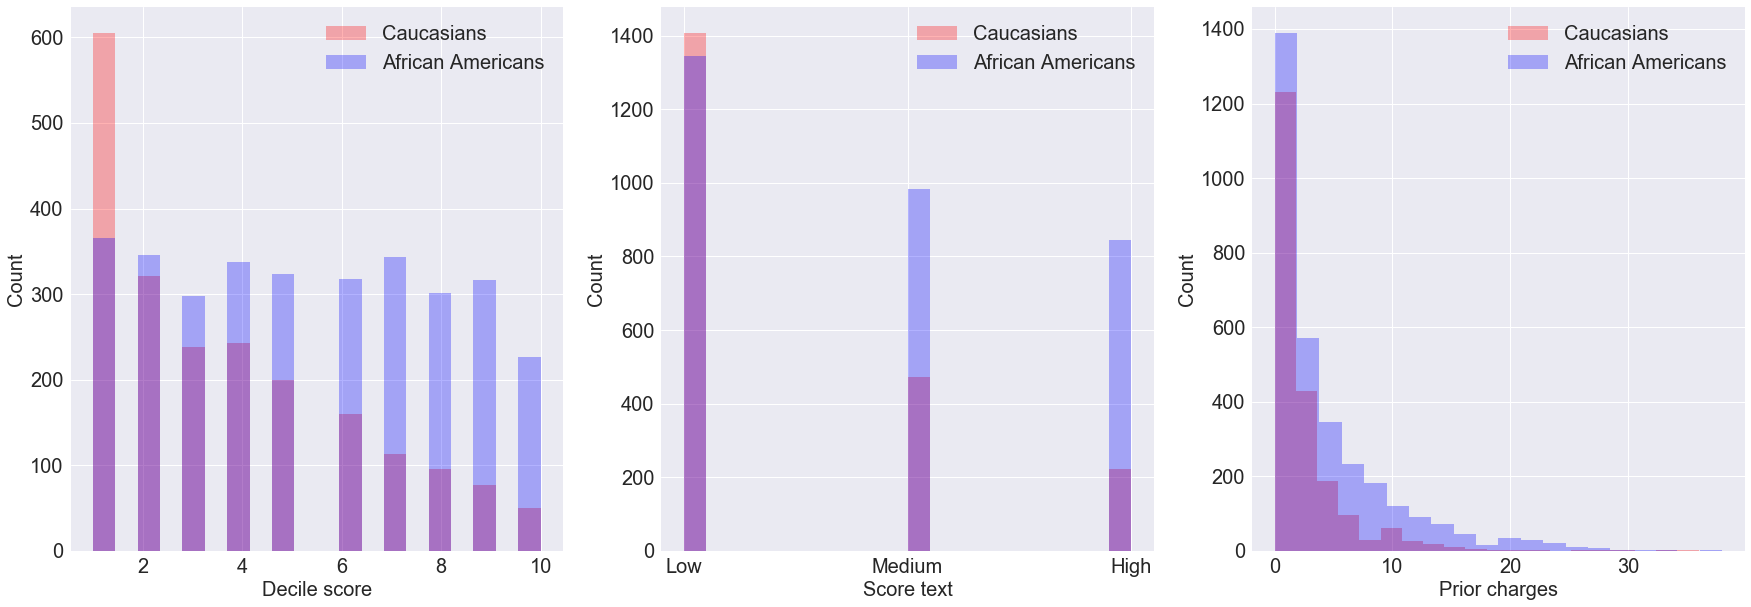

In [29]:
fig, axes = plt.subplots(1,3,figsize=(30,10))
axes[0].hist(compas_caucasians['decile_score'],label='Caucasians',alpha=0.3,bins=20,color='r')
axes[0].hist(compas_african['decile_score'],label='African Americans',alpha=0.3,bins=20,color='b')
axes[0].legend(fontsize=20)
axes[0].set_xlabel('Decile score',fontsize=20)
axes[0].set_ylabel('Count',fontsize=20)
axes[0].tick_params(labelsize=20)

axes[1].hist(compas_caucasians['score_text'],label='Caucasians',alpha=0.3,bins=20,color='r')
axes[1].hist(compas_african['score_text'],label='African Americans',alpha=0.3,bins=20,color='b')
axes[1].legend(fontsize=20)
axes[1].set_xlabel('Score text',fontsize=20)
axes[1].set_xticklabels(['Low', 'Medium','High'], fontsize=10)
axes[1].set_xticks(np.arange(0,3,1))
axes[1].set_ylabel('Count',fontsize=20)
axes[1].tick_params(labelsize=20)

axes[2].hist(compas_caucasians['priors_count'],label='Caucasians',alpha=0.3,bins=20,color='r')
axes[2].hist(compas_african['priors_count'],label='African Americans',alpha=0.3,bins=20,color='b')
axes[2].legend(fontsize=20)
axes[2].set_xlabel('Prior charges',fontsize=20)
axes[2].set_ylabel('Count',fontsize=20)
axes[2].tick_params(labelsize=20)

**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

*your answer here*  
Data may be collected in different social-econimical environment/community, where race is associated with factors related to crime. 
Decile score (and score text) may be calculated from confounders of race, such as education, social background, level of poverty, etc. 
They may sample African-American more from poorer and unsafer community, and Caucasians from richer community, which results in the difference of prior crime charge number.


**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

In [30]:
# your code here
scaler = MinMaxScaler()
X_train_compas_scaled = X_train_compas.copy()
X_train_compas_scaled[X_train_compas_scaled.columns] = scaler.fit_transform(X_train_compas_scaled[X_train_compas_scaled.columns])

X_test_compas_scaled = X_test_compas.copy()
X_test_compas_scaled[X_test_compas_scaled.columns] = scaler.transform(X_test_compas_scaled[X_test_compas_scaled.columns])

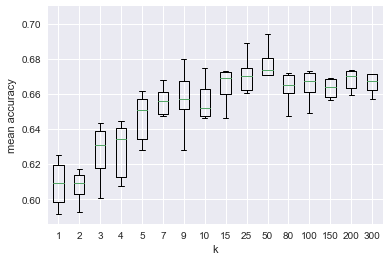

In [31]:
ks_compas = [1,2,3,4,5,7,9,10,15,25,50,80,100,150,200,300]
knnmodels_compas = []
cv_scores_compas = []
for k in ks_compas:
    KNN = KNeighborsClassifier(n_neighbors = k)
    # train model with cv of 5
    cv_score = cross_val_score(KNN, X_train_compas_scaled,y_train_compas,cv=5)
    mean = np.mean(cv_score)
    cv_score = np.append(cv_score,mean)
    cv_scores_compas.append(cv_score)
    knnmodels_compas.append(KNN.fit(X_train_compas_scaled,y_train_compas))
fig,ax=plt.subplots(1,1)
ax.boxplot(cv_scores_compas)
ax.set_xticklabels(ks_compas)
ax.set_ylabel('mean accuracy')
ax.set_xlabel('k')
plt.show()

Select k=50.

In [32]:
KNN_compas = KNeighborsClassifier(n_neighbors = 50)
KNN_compas.fit(X_train_compas_scaled,y_train_compas)
knn_train_pred_compas = KNN_compas.predict(X_train_compas_scaled)
knn_test_pred_compas = KNN_compas.predict(X_test_compas_scaled)
accuracy_train_compas = accuracy_score(y_train_compas,knn_train_pred_compas)
accuracy_test_compas = accuracy_score(y_test_compas,knn_test_pred_compas)
mis_train_compas = 1-accuracy_train_compas
mis_test_compas = 1-accuracy_test_compas
print('The misclassification rate on train set of KNN model with k=7 is {}%'.format(100*mis_train_compas))
print('The misclassification rate on test set of KNN model with k=7 is {}%'.format(100*mis_test_compas))

The misclassification rate on train set of KNN model with k=7 is 31.456350010127608%
The misclassification rate on test set of KNN model with k=7 is 33.036437246963565%


In [33]:
logit_compas=LogisticRegression(C=100000).fit(X_train_compas_scaled.values, y_train_compas)
y_train_pred_logit_compas=logit_compas.predict(X_train_compas_scaled.values)
y_test_pred_logit_compas=logit_compas.predict(X_test_compas_scaled.values)

print('The misclassification rate on the training set is {}%.'.format(100-accuracy_score(y_train_compas,y_train_pred_logit_compas)*100))
print('The misclassification rate on the test set is {}%.'.format(100-accuracy_score(y_test_compas,y_test_pred_logit_compas)*100))

The misclassification rate on the training set is 30.362568361353055%.
The misclassification rate on the test set is 31.821862348178144%.


**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [34]:
# your code here
X_train_compas_scaled_norace=X_train_compas_scaled.drop(droplist[0:6],axis=1)
X_test_compas_scaled_norace=X_test_compas_scaled.drop(droplist[0:6],axis=1)

KNN_compas_norace = KNeighborsClassifier(n_neighbors = 50)
KNN_compas_norace.fit(X_train_compas_scaled_norace,y_train_compas)
knn_train_pred_compas_norace = KNN_compas_norace.predict(X_train_compas_scaled_norace)
knn_test_pred_compas_norace = KNN_compas_norace.predict(X_test_compas_scaled_norace)
accuracy_train_compas_norace = accuracy_score(y_train_compas,knn_train_pred_compas_norace)
accuracy_test_compas_norace = accuracy_score(y_test_compas,knn_test_pred_compas_norace)
mis_train_compas_norace = 1-accuracy_train_compas_norace
mis_test_compas_norace = 1-accuracy_test_compas_norace
print('The misclassification rate on train set of KNN model with k=7 is {}%'.format(100*mis_train_compas_norace))
print('The misclassification rate on test set of KNN model with k=7 is {}%'.format(100*mis_test_compas_norace))

The misclassification rate on train set of KNN model with k=7 is 30.50435487137938%
The misclassification rate on test set of KNN model with k=7 is 33.52226720647773%


In [35]:
logit_compas_norace=LogisticRegression(C=100000).fit(X_train_compas_scaled_norace.values, y_train_compas)
y_train_pred_logit_compas_norace=logit_compas_norace.predict(X_train_compas_scaled_norace.values)
y_test_pred_logit_compas_norace=logit_compas_norace.predict(X_test_compas_scaled_norace.values)

print('The misclassification rate on the training set is {}%.'.format(100-accuracy_score(y_train_compas,y_train_pred_logit_compas_norace)*100))
print('The misclassification rate on the test set is {}%.'.format(100-accuracy_score(y_test_compas,y_test_pred_logit_compas_norace)*100))

The misclassification rate on the training set is 30.423334008507183%.
The misclassification rate on the test set is 31.7408906882591%.


In [36]:
cm4 = confusion_matrix(y_test_compas[X_test_compas['race_Caucasian']==1], knn_test_pred_compas_norace[X_test_compas['race_Caucasian']==1])
print('In Caucasian, KNN:')
print(cm4)
print('False positive rate: {}%'.format(100*cm4.ravel()[1]/(cm4.ravel()[1]+cm4.ravel()[0])))
print('False negative rate: {}%'.format(100*cm4.ravel()[2]/(cm4.ravel()[2]+cm4.ravel()[3])))
cm5 = confusion_matrix(y_test_compas[X_test_compas['race_African-American']==1], knn_test_pred_compas_norace[X_test_compas['race_African-American']==1])
print('In African American, KNN:')
print(cm5)
print('False positive rate: {}%'.format(100*cm5.ravel()[1]/(cm5.ravel()[1]+cm5.ravel()[0])))
print('False negative rate: {}%'.format(100*cm5.ravel()[2]/(cm5.ravel()[2]+cm5.ravel()[3])))

cm6 = confusion_matrix(y_test_compas[X_test_compas['race_Caucasian']==1], y_test_pred_logit_compas_norace[X_test_compas['race_Caucasian']==1])
print('In Caucasian, logistic:')
print(cm6)
print('False positive rate: {}%'.format(100*cm6.ravel()[1]/(cm6.ravel()[1]+cm6.ravel()[0])))
print('False negative rate: {}%'.format(100*cm6.ravel()[2]/(cm6.ravel()[2]+cm6.ravel()[3])))
#lasso logistic 
cm7 = confusion_matrix(y_test_compas[X_test_compas['race_African-American']==1], y_test_pred_logit_compas_norace[X_test_compas['race_African-American']==1])
print('In African American, logistic:')
print(cm7)
print('False positive rate: {}%'.format(100*cm7.ravel()[1]/(cm7.ravel()[1]+cm7.ravel()[0])))
print('False negative rate: {}%'.format(100*cm7.ravel()[2]/(cm7.ravel()[2]+cm7.ravel()[3])))


In Caucasian, KNN:
[[221  43]
 [ 83  74]]
False positive rate: 16.28787878787879%
False negative rate: 52.86624203821656%
In African American, KNN:
[[219  91]
 [128 197]]
False positive rate: 29.35483870967742%
False negative rate: 39.38461538461539%
In Caucasian, logistic:
[[223  41]
 [ 80  77]]
False positive rate: 15.530303030303031%
False negative rate: 50.955414012738856%
In African American, logistic:
[[208 102]
 [106 219]]
False positive rate: 32.903225806451616%
False negative rate: 32.61538461538461%


The missclarification rate is not quite different comparing the models with race. False negative rate for Caucasians is much higher than African American, while false positive rate is much lower, which may indicate that Caucasians are more likely to get away from being convicted.

**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

*your answer here*  
The models above, with or without race as predictor, give similar missclasification rates. Possible reason is that other predictors are highly correlated with race ("colinearity"), such as number of prior charges and COMPAS score mentioned in Q4.2, and maybe also length of stay, charge times in junvenile, etc. So removing race doesn't have a great influence. Also, there are some unmeasured factors that can introduce bias. Judges in court may be biased and convict African American more due to the history of race discrimination, and we cannot collect high quality data about this. Thus, although we exclude race from the models, there may still be bias.

---